#### > Gozde Orhan

# CIFAR-10 Image Dataset Multiclass Clasification          

## 1. Introduction
This documentation consists of a deep learning model for the well-known color image classification problem, **CIFAR-10.** Throughout the report, the methodology used to build the model, graphs and tables regarding the models and, a section for conclusion will be given in detail.

As an initial work, a simple deep learning model is built and through building more advanced models by *adding layers, tuning size's of layers, use of regularizers, utilizing dropout and batch normalization*, the boundary of overfitting is aimed. The model aims to predict the classes of images with high accuracy while maintaining a low loss value. 

### 1.1 Hardware
The models were implemented on a local computer with Core i7 processors and 16GB RAM. 

## 2. Method
This project will investigate the effect of following hyperparameters and methods on convolutional networks:

- Number of hidden layers
- Number of nodes in a layer
- Regularizers
- Dropout
- Batch Normalization
- Optimizer choice

In addition to given methods, 'Callbacks' method is used for every trial done in scope of this work.

### 2.1 Problem Definition and Dataset
The model is concerned with a well-known deep learning problem of classifying colour images. It is trying to predict the classes of colored images. One of the available datasets for this model is named CIFAR-10 which consists of:
- 60000 32x32 colour images 
- in 10 classes, 
- with 6000 images per class. 

There are **50000 training images** and **10000 test images**. Since there are 10 classes and and a single label to be used for each image, CIFAR-10 is considered to be a **multiclass classification problem.**

### 2.2 Data Preparation

Prior to the training, data should be preprocessed and reshaped into the shape that network expects. Since the images in the CIFAR-10 dataset is consists of 60000 color images with three dimensions such as height, width and color depth, **convnets** will be used as main layers of the model. Since a convnet takes as input tensors of shape (height, width, channel), reshaping was not required. 

However, the type of the data was uint8 with values in the [0,255] interval thus needed to be transformed into a float32 with values between 0 and 1. In addition, the labels are vectorized and encoded in scope of data preparation.

In [1]:
#Import dataset from Keras
from tensorflow.keras.datasets import cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passi

In [2]:
#Image data transformation to values between 0 and 1
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

#Image label vectorization
#Import 'to_categorical' to be used in label vectorization
from keras.utils import to_categorical
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

Using TensorFlow backend.


## 3. Models
In this section, there will be two models to be explained: the initial model and the final model. In addition, the trials lead to the final model will also be included.

## 3.1 Initial Model

Convolutional neural networks (CNNs), are deep learning algorithms that are particularly powerful for analysis of images because of the following reasons (Chollet, page 123):

- The patterns they learn are translation invariant. After learning a certain pattern in the lower-right corner of a picture, a convnet can recognize it anywhere: for example, in the upper-left corner. A densely connected network would have to learn the pattern anew if it appeared at a new location. This makes convnets data efficient when processing images (because the visual world is fundamentally translation invariant): they need fewer training samples to learn representations that have generalization power.
- They can learn spatial hierarchies of patterns. A first convolution layer will learn small local patterns such as edges, a second convolution layer will learn larger patterns made of the features of the first layers, and so on. This allows convnets to efficiently learn increasingly complex and abstract visual concepts (because the visual world is fundamentally spatially hierarchical).

Due to the fact that CIFAR-10 consist of color images, it has been concluded that use of CNNs will be more efficient.

In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential

Chollet mentions in his book that, the output of Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels) and the width and height dimensions tend to shrink as you go deeper in the network. After use of these convolutional layers, we must feed the last output tensor into a densely connected classifier which is a *Dense* layer. **These classifiers process vectors**, which are 1D, whereas the current output is a 3D tensor. Thus, we have to flatten the **3D outputs to 1D**, and then add a Dense layer.

**Therefore, as an initial model, a model with minimum number of convolutional and dense layers with significantly small units are used.**

In [4]:
model = models.Sequential()
model.add(Conv2D(16,(3,3), activation = 'relu', input_shape = (32,32,3)))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

In [5]:
#Architecture of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                36010     
Total params: 36,458
Trainable params: 36,458
Non-trainable params: 0
_________________________________________________________________


### 3.1.1 Callback
In scope of this work, beside the aims listed above, one of the aims is to beat the final model's performance in previous work of mine (~65% accuracy). Therefore, in order to use time more efficiently, a callback method is used. This callback allows you to interrupt training as soon as you start overfitting *(EarlyStopping)*, which lets you continually save the model during training *(ModelCheckpoint)*.

In [6]:
import tensorflow.keras

callbacks_list = [tensorflow.keras.callbacks.EarlyStopping(monitor='val_acc',
                                                patience=1,
        ),
        tensorflow.keras.callbacks.ModelCheckpoint(
            filepath='weights.{epoch:02d}-{val_loss:.2f}.hdf5',
            monitor='val_loss',
            save_best_only=True,
)]

## 3.2 Scaling up and tuning

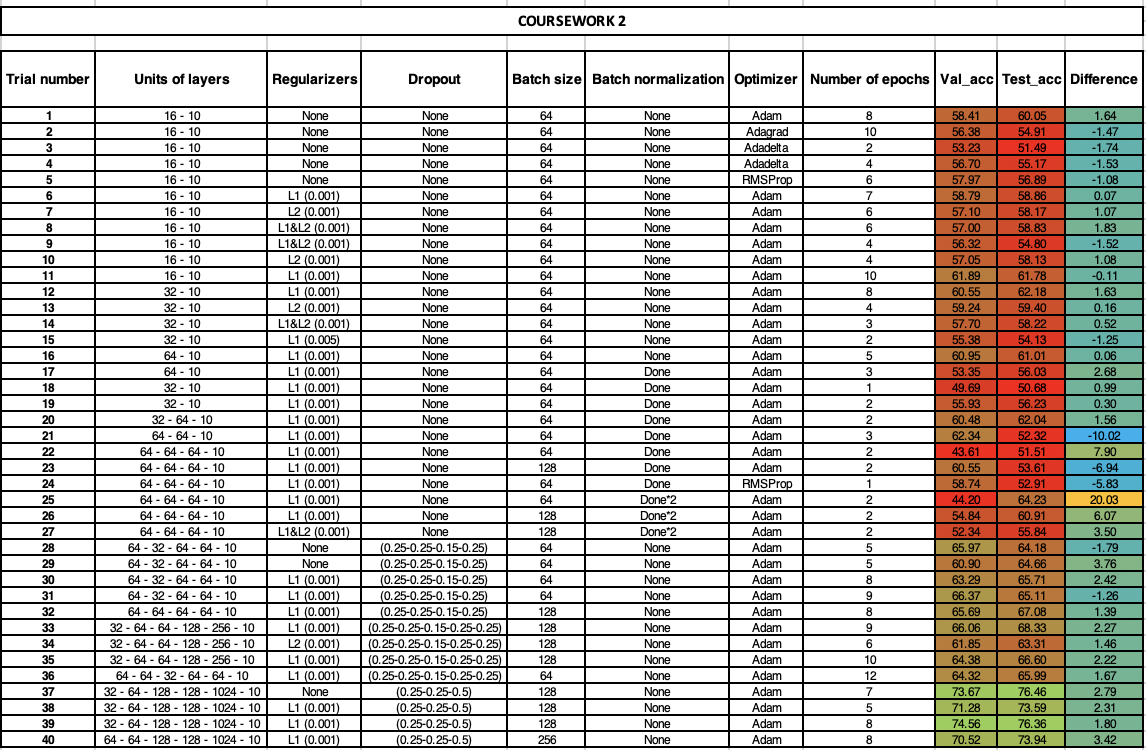

> - Total number of 40 experiments are done while building the model and the process of scaling it up. At first, a simpler model is built and designated as the initial model. 

> - Initial model had a test accurancy of 60.05%. Therefore test accurancy of 70% is aimed.

> - For the first 5 experiment, the effect of optimizer choice in the convolutional models are observed. It is seen that in terms of overfitting and higher accuracies, Adam performed better. Therefore, Adam is designated as optimizer for the initial and final model.

> - Through experiments number 6 to 11, by keeping other parameters constant, the effect of regularizer choice is observed. It it seen that L1 outperforms L2 and, L1 and L2.

> - Through experiments 12 to 16, L1's performance is observed with bigger units, which in fact yielded in higher accuracies.

> - Through experiments 17 to 27, the effect of batch normalization is observed. The batch normalization is done after a 'Conv2D' layer. However, the model performed worse despite bigger units, bigger layers, different optimizer, different regularizers and batch size. Thus, batch normalization layers was not used for final model.

> - Through experiments 28 to 45, effects of unit sizes, number of layers, dropout method and batch size are observed. Dropout method as well as the increase in number of layers and unit sizes yielded in significantly better performing models.

> - Due to non-negligible increase in model running times, the yet best achieved model is designated as final model. This model have an validation and test accuracy of 76.33 which is relatively high for CIFAR-10 dataset.

## 3.3 Final Model
After experimenting with different hyperparameters and methods, the below final model is built.

In [7]:
model = Sequential()
model.add(Conv2D(32,(3, 3), kernel_regularizer=regularizers.l1(0.001), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(64,(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128,(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [8]:
#Architecture of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 128)        

### 3.3.1 Mesaure of Succes
- In terms of measuring the success, the *accuracy* will be monitored which is the representation of the fraction of the images that are correctly classified. 
- In addition, due to the fact that CIFAR-10 is a multilabel classification problem with 10 different output classes, a *softmax* activation is used for the last layer. 
- Therefore, the best loss function to be use in this model is *categorical_crossentropy*  which measures the distance between two probability distributions: between the probability distrubution output by the network and the true distribution of the labels. 
- In the mean time, by minimizing the loss through the optimizer, *Adam*, network will be trained.

### 3.3.2 Evaluation Protocol
During the process of tuning, the performance of the model on validation and test set were used. Even tough, there are several ways to create a validation set, **hold-out validation** is used for this model. In this validation, some fraction of the data is set apart to be used as a validation set. There are **40000 images for partial training set** and **10000 for validation set.**

In [9]:
model.compile(tensorflow.keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['acc'])

val_images = train_images[:10000]
partial_train_images = train_images[10000:]
val_labels = train_labels[:10000]
partial_train_labels = train_labels[10000:]

history = model.fit(partial_train_images, partial_train_labels, 
                      epochs = 10,
                      batch_size = 128, 
                      callbacks=callbacks_list,
                      validation_data = (val_images, val_labels))

import math
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
last_index=len(val_acc)-1
print('Validation accuracy is: ' + str(round(val_acc[last_index] * 100, 2)) + '%.')

import numpy as np
print('Overfitting starts at: ' + str(np.argmin(val_loss) + 1))

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 85s 2ms/sample - loss: 1.6890 - acc: 0.3882 - val_loss: 1.2838 - val_acc: 0.5614
Epoch 2/10
40000/40000 [==============================] - 80s 2ms/sample - loss: 1.2523 - acc: 0.5623 - val_loss: 1.0730 - val_acc: 0.6375
Epoch 3/10
40000/40000 [==============================] - 79s 2ms/sample - loss: 1.0831 - acc: 0.6279 - val_loss: 0.9749 - val_acc: 0.6685
Epoch 4/10
40000/40000 [==============================] - 79s 2ms/sample - loss: 0.9626 - acc: 0.6726 - val_loss: 0.8815 - val_acc: 0.7000
Epoch 5/10
40000/40000 [==============================] - 79s 2ms/sample - loss: 0.8862 - acc: 0.7000 - val_loss: 0.8386 - val_acc: 0.7138
Epoch 6/10
40000/40000 [==============================] - 79s 2ms/sample - loss: 0.8218 - acc: 0.7232 - val_loss: 0.7828 - val_acc: 0.7381
Epoch 7/10
40000/40000 [==============================] - 80s 2ms/sample - loss: 0.7775 - acc: 0.7394 - val_loss: 0.

### 3.3.3 Plotting
Visualisation is a very powerful tool to gain insight regarding to the performance of the model. In this section, the accuracies and the loss values of both training and validation data will be ploted.

In [10]:
def comparison_plot(x, 
                    y_A, style_A, label_A, 
                    y_B, style_B, label_B, 
                    title, x_label, y_label):
    
    import matplotlib.pyplot as plt
    plt.clf()
    plt.plot(x, y_A, style_A, label = label_A)
    plt.plot(x, y_B, style_B, label = label_B)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

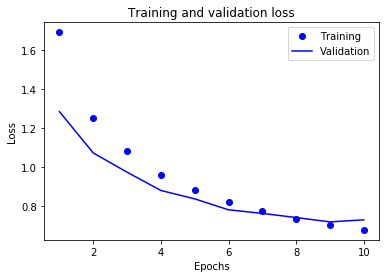

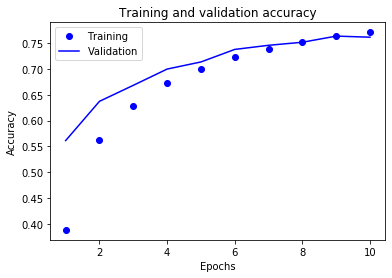

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']
comparison_plot(range(1, len(loss) + 1), 
                loss, 'bo', 'Training',
                val_loss, 'b', 'Validation',
                'Training and validation loss',
                'Epochs',
                'Loss')

acc = history.history['acc']
val_acc = history.history['val_acc']
comparison_plot(range(1, len(loss) + 1), 
                acc, 'bo', 'Training',
                val_acc, 'b', 'Validation',
                'Training and validation accuracy',
                'Epochs',
                'Accuracy')

### 3.3.4 Test on test set
After training the partial training data and evaluating on the validation set, model is tested on the test set and the test accuracy is observed. In order to decide the number epochs, by using argmin function, overfitting stage is observed.  

In [12]:
model = Sequential()
model.add(Conv2D(32,(3, 3), kernel_regularizer=regularizers.l1(0.001), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(64,(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128,(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer = 'Adam',loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_images,train_labels, epochs = np.argmin(val_loss) + 1, batch_size = 128)

results = model.evaluate(test_images, test_labels)

#Printing the test_acc
print('Test accuracy is: ' + str(round(results[1] * 100, 2)) + '%.')

Epoch 1/9
50000/50000 [==============================] - 89s 2ms/sample - loss: 1.7225 - accuracy: 0.3783
Epoch 2/9
50000/50000 [==============================] - 87s 2ms/sample - loss: 1.2526 - accuracy: 0.5667
Epoch 3/9
50000/50000 [==============================] - 88s 2ms/sample - loss: 1.0596 - accuracy: 0.6378
Epoch 4/9
50000/50000 [==============================] - 88s 2ms/sample - loss: 0.9438 - accuracy: 0.6807
Epoch 5/9
50000/50000 [==============================] - 91s 2ms/sample - loss: 0.8505 - accuracy: 0.7138
Epoch 6/9
50000/50000 [==============================] - 96s 2ms/sample - loss: 0.8023 - accuracy: 0.7336
Epoch 7/9
50000/50000 [==============================] - 90s 2ms/sample - loss: 0.7487 - accuracy: 0.7508
Epoch 8/9
50000/50000 [==============================] - 90s 2ms/sample - loss: 0.7128 - accuracy: 0.7647
Epoch 9/9
10000/10000 [==============================] - 5s 521us/sample - loss: 0.7010 - accuracy: 0.7737
Test accuracy is: 77.37%.


### 3.3.5 Predictions of the Final Model

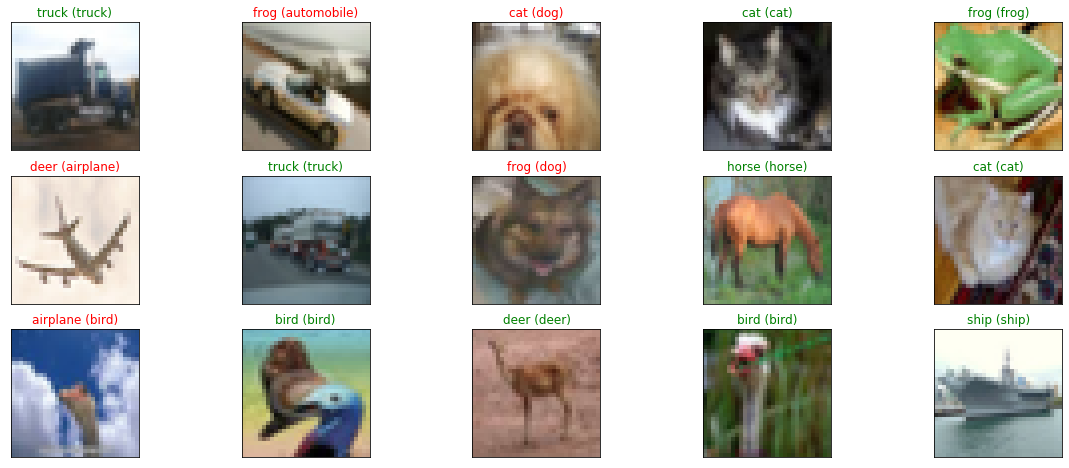

In [13]:
#https://colab.research.google.com/github/margaretmz/deep-learning/blob/master/fashion_mnist_keras.ipynb#scrollTo=d44TznbgZZgm

import matplotlib.pyplot as plt

labels = ['airplane',
          'automobile',
          'bird',
          'cat',
          'deer',
          'dog',
          'frog',
          'horse',
          'ship',
          'truck']

y_hat = model.predict(test_images)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(test_images.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(test_images[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(test_labels[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

plt.show()

## 4. Results

**Optimizer choice** <br>
No significant differences among optimizers are observed but still Adam slightly performed better. This may be due to the fact that Adam realizes the benefits of both AdaGrad and RMSProp. Specifically:
- Adaptive Gradient Algorithm (AdaGrad) that maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).
- Root Mean Square Propagation (RMSProp) that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).

https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

**Regularizers** <br>
L1 outperformed L2 and L1&L2. Thus, L1 regularizer is used for final model. The regularizer significantly helped avoiding overfitting. It is clearly observed that during previous work, the difference between val_acc and test_acc was higher. The better performance may be due to the fact that L1:
- Produces sparse solutions.
- It is robust to outliers.

https://www.quora.com/Why-is-L1-regularization-better-than-L2-regularization-provided-that-all-Norms-are-equivalent

**Batch Normalization** <br>
Batch normalization significantly worsen the performance of the model, beside the fact that it caused huge accuracy differences between validation and test set. Therefore, this method is not used for final model.

**Dropout** <br>
Dropout method significantly enchanced the performance of the model. Thus, dropout method is used for final model. This may be due to the fact that the method:
- Simulates a sparse activation from a given layer, which interestingly, in turn, encourages the network to actually learn a sparse representation as a side-effect. As such, it may be used as an alternative to activity regularization for encouraging sparse representations in autoencoder models.

https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/